### Introduction
March Madness is upon us once again and, as per usual, I've watched exactly zero college basketball games. My typical routine at this time of year is to pretty much throw away my money buying into March Madness groups with my friends - many of whom watch a lot of college basketball and spend hours "studying" to create the perfect bracket. I, on the other hand, spend about ten minutes picking teams with no real rhyme or reason and end up with a bracket that busts in the first or second round. I am determined to not be that guy this year. Instead, I decided to use machine learning to help me create a bracket that will (hopefully) have a real shot at winning.

### The Plan
I took the team statistics for every Division I college basketball team from 2007 to 2015 from [sports-reference](https://www.sports-reference.com/cbb/seasons/) and game results from the same time period from [Kaggle](https://www.kaggle.com/c/mens-machine-learning-competition-2019). I selected the features for my model from the sports-reference data, using the feature vector as my X. My Y was created from the Kaggle data and represented either a win or a loss.

In [242]:
#Stuff I need
import numpy as np
import pandas as pd
import collections
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [220]:
#Read in the data files
team_id_df = pd.read_csv('Teams.csv') #Team IDs
#Rename columns for consistency
team_id_df = team_id_df.rename(index=str,
                               columns = {'Team_Id':'ID', 'Team_Name':'School'})

reg_seas_compact_df = pd.read_csv('RegularSeasonCompactResults.csv') #Reg season game results
tourney_compact_df = pd.read_csv('TourneyCompactResults.csv') #Tournament game results

#Only looking at 2007-2015 to keep it relevant and managable running time wise
reg_seas_compact_df = reg_seas_compact_df[reg_seas_compact_df['Season']>2006]
reg_seas_compact_df = reg_seas_compact_df[reg_seas_compact_df['Season']<2016]
tourney_compact_df = tourney_compact_df[tourney_compact_df['Season']>2006]
tourney_compact_df = tourney_compact_df[tourney_compact_df['Season']<2016]

#Basic team stats
seven_basic = pd.read_csv("2007 Basic Team Stats.csv", header=1)
seven_basic['Season'] = 2007
eight_basic = pd.read_csv("2008 Basic Team Stats.csv", header=1)
eight_basic['Season'] = 2008
nine_basic = pd.read_csv("2009 Basic Team Stats.csv", header=1)
nine_basic['Season'] = 2009
ten_basic = pd.read_csv("2010 Basic Team Stats.csv", header=1)
ten_basic['Season'] = 2010
eleven_basic = pd.read_csv("2011 Basic Team Stats.csv", header=1)
eleven_basic['Season'] = 2011
twelve_basic = pd.read_csv("2012 Basic Team Stats.csv", header=1)
twelve_basic['Season'] = 2012
thirteen_basic = pd.read_csv("2013 Basic Team Stats.csv", header=1)
thirteen_basic['Season'] = 2013
fourteen_basic = pd.read_csv("2014 Basic Team Stats.csv", header=1)
fourteen_basic['Season'] = 2014
fifteen_basic = pd.read_csv("2015 Basic Team Stats.csv", header=1)
fifteen_basic['Season'] = 2015
#Read in current year basic stats here
nineteen_basic = pd.read_csv("2019 Basic Team Stats.csv", header=1)
nineteen_basic['Season'] = 2019

#Put them all in one dataframe
frames_basic = [seven_basic, eight_basic, nine_basic, ten_basic,
               eleven_basic, twelve_basic, thirteen_basic, fourteen_basic, fifteen_basic, nineteen_basic]
basic_team_stats_df = pd.concat(frames_basic)

#Get rid of weird useless column and take out 'NCAA' from sports ref data
#there was a weird invisible character so I had to do it the iloc way
basic_team_stats_df = basic_team_stats_df.drop('Unnamed: 15', axis=1)
for i in range(len(basic_team_stats_df['School'])):
    school = basic_team_stats_df.iloc[i,0]
    if 'NCAA' in school:
        school = school[0:-5]
        basic_team_stats_df.iloc[i,0] = school
basic_team_Stats_df = basic_team_stats_df.sort_values('School')

#Advanced team stats
seven_adv = pd.read_csv("2007 Advanced Team Stats.csv", header=1)
seven_adv['Season'] = 2007
eight_adv = pd.read_csv("2008 Advanced Team Stats.csv", header=1)
eight_adv['Season'] = 2008
nine_adv = pd.read_csv("2009 Advanced Team Stats.csv", header=1)
nine_adv['Season'] = 2009
ten_adv = pd.read_csv("2010 Advanced Team Stats.csv", header=1)
ten_adv['Season'] = 2010
eleven_adv = pd.read_csv("2011 Advanced Team Stats.csv", header=1)
eleven_adv['Season'] = 2011
twelve_adv = pd.read_csv("2012 Advanced Team Stats.csv", header=1)
twelve_adv['Season'] = 2012
thirteen_adv = pd.read_csv("2013 Advanced Team Stats.csv", header=1)
thirteen_adv['Season'] = 2013
fourteen_adv = pd.read_csv("2014 Advanced Team Stats.csv", header=1)
fourteen_adv['Season'] = 2014
fifteen_adv = pd.read_csv("2015 Advanced Team Stats.csv", header=1)
fifteen_adv['Season'] = 2015
#Read in current year basic stats here
nineteen_adv = pd.read_csv("2019 Advanced Team Stats.csv", header=1)
nineteen_adv['Season'] = 2019

frames_adv = [seven_adv, eight_adv, nine_adv, ten_adv, eleven_adv, twelve_adv,
             thirteen_adv, fourteen_adv, fifteen_adv, nineteen_adv]
adv_team_stats_df = pd.concat(frames_adv)
adv_team_stats_df = adv_team_stats_df.drop('Unnamed: 15', axis=1)

for i in range(len(adv_team_stats_df['School'])):
    school = adv_team_stats_df.iloc[i,0]
    if 'NCAA' in school:
        school = school[0:-5]
        adv_team_stats_df.iloc[i,0] = school
adv_team_stats_df = adv_team_stats_df.sort_values('School')

In [221]:
#The team names aren't the same across dataframes. This is to fix that.
def nameStandardizer(df):
    df['School'] = df['School'].replace('Mount St. Mary\'s', 'Mt St Mary\'s')
    df['School'] = df['School'].replace('(State)', 'St', regex=True) 
    df['School'] = df['School'].replace('Albany (NY)', 'Albany NY') 
    df['School'] = df['School'].replace('Boston University', 'Boston Univ')
    df['School'] = df['School'].replace('Central Michigan', 'C Michigan')
    df['School'] = df['School'].replace('(Eastern)', 'E', regex=True)
    df['School'] = df['School'].replace('Louisiana St', 'LSU')
    df['School'] = df['School'].replace('North Carolina St', 'NC State')
    df['School'] = df['School'].replace('Southern California', 'USC')
    df['School'] = df['School'].replace('University of California', 'California', regex=True) 
    df['School'] = df['School'].replace('American', 'American Univ')
    df['School'] = df['School'].replace('Arkansas-Little Rock', 'Ark Little Rock')
    df['School'] = df['School'].replace('Arkansas-Pine Bluff', 'Ark Pine Bluff')
    df['School'] = df['School'].replace('Bowling Green St', 'Bowling Green')
    df['School'] = df['School'].replace('Brigham Young', 'BYU')
    df['School'] = df['School'].replace('Cal Poly', 'Cal Poly SLO')
    df['School'] = df['School'].replace('Centenary (LA)', 'Centenary')
    df['School'] = df['School'].replace('Central Connecticut St', 'Central Conn')
    df['School'] = df['School'].replace('Charleston Southern', 'Charleston So')
    df['School'] = df['School'].replace('Coastal Carolina', 'Coastal Car')
    df['School'] = df['School'].replace('College of Charleston', 'Col Charleston')
    df['School'] = df['School'].replace('Cal St Fullerton', 'CS Fullerton')
    df['School'] = df['School'].replace('Cal St Sacramento', 'CS Sacramento')
    df['School'] = df['School'].replace('Cal St Bakersfield', 'CS Bakersfield')
    df['School'] = df['School'].replace('Cal St Northridge', 'CS Northridge')
    df['School'] = df['School'].replace('East Tennessee St', 'ETSU')
    df['School'] = df['School'].replace('Detroit Mercy', 'Detroit')
    df['School'] = df['School'].replace('Fairleigh Dickinson', 'F Dickinson')
    df['School'] = df['School'].replace('Florida Atlantic', 'FL Atlantic')
    df['School'] = df['School'].replace('Florida Gulf Coast', 'FL Gulf Coast')
    df['School'] = df['School'].replace('Florida International', 'Florida Intl')
    df['School'] = df['School'].replace('George Washington', 'G Washington')
    df['School'] = df['School'].replace('Georgia Southern', 'Ga Southern')
    df['School'] = df['School'].replace('Gardner-Webb', 'Gardner Webb')
    df['School'] = df['School'].replace('Illinois-Chicago', 'IL Chicago')
    df['School'] = df['School'].replace('Kent St', 'Kent')
    df['School'] = df['School'].replace('Kennesaw St', 'Kennesaw')
    df['School'] = df['School'].replace('Little Rock', 'Ark Little Rock')
    df['School'] = df['School'].replace('Long Island University', 'Long Island')
    df['School'] = df['School'].replace('Loyola Marymount', 'Loy Marymount')
    df['School'] = df['School'].replace('Loyola (MD)', 'Loyola MD')
    df['School'] = df['School'].replace('Loyola (IL)', 'Loyola-Chicago')
    df['School'] = df['School'].replace('Massachusetts-Lowell', 'MA Lowell')
    df['School'] = df['School'].replace('Maryland-Eastern Shore', 'MD E Shore')
    df['School'] = df['School'].replace('Miami (FL)', 'Miami FL')
    df['School'] = df['School'].replace('Miami (OH)', 'Miami OH')
    df['School'] = df['School'].replace('Missouri-Kansas City', 'Missouri KC')
    df['School'] = df['School'].replace('Monmouth', 'Monmouth NJ')
    df['School'] = df['School'].replace('Mississippi Valley St', 'MS Valley St')
    df['School'] = df['School'].replace('Montana St', 'MTSU')
    df['School'] = df['School'].replace('Northern Colorado', 'N Colorado')
    df['School'] = df['School'].replace('North Dakota St', 'N Dakota St')
    df['School'] = df['School'].replace('Northern Illinois', 'N Illinois')
    df['School'] = df['School'].replace('Northern Kentucky', 'N Kentucky')
    df['School'] = df['School'].replace('North Carolina A&T', 'NC A&T')
    df['School'] = df['School'].replace('North Carolina Central', 'NC Central')
    df['School'] = df['School'].replace('Pennsylvania', 'Penn')
    df['School'] = df['School'].replace('South Carolina St', 'S Carolina St')
    df['School'] = df['School'].replace('Southern Illinois', 'S Illinois')
    df['School'] = df['School'].replace('Stateanford', 'Stanford')
    df['School'] = df['School'].replace('UC-Santa Barbara', 'Santa Barbara')
    df['School'] = df['School'].replace('Southeastern Louisiana', 'SE Louisiana')
    df['School'] = df['School'].replace('Southeast Missouri St', 'SE Missouri St')
    df['School'] = df['School'].replace('Stephen F. Austin', 'SF Austin')
    df['School'] = df['School'].replace('Southern Methodist', 'SMU')
    df['School'] = df['School'].replace('Southern Mississippi', 'Southern Miss')
    df['School'] = df['School'].replace('Southern', 'Southern Univ')
    df['School'] = df['School'].replace('St. Bonaventure', 'St Bonaventure')
    df['School'] = df['School'].replace('St. Francis (NY)', 'St Francis NY')
    df['School'] = df['School'].replace('Saint Francis (PA)', 'St Francis PA')
    df['School'] = df['School'].replace('St. John\'s (NY)', 'St John\'s')
    df['School'] = df['School'].replace('Saint Joseph\'s', 'St Joseph\'s PA')
    df['School'] = df['School'].replace('Saint Louis', 'St Louis')
    df['School'] = df['School'].replace('Saint Mary\'s (CA)', 'St Mary\'s CA')
    df['School'] = df['School'].replace('Saint Peter\'s', 'St Peter\'s')
    df['School'] = df['School'].replace('Texas A&M-Corpus Christian', 'TAM C. Christian')
    df['School'] = df['School'].replace('Texas Christian', 'TCU')
    df['School'] = df['School'].replace('Tennessee-Martin', 'TN Martin')
    df['School'] = df['School'].replace('Texas-Rio Grande Valley', 'UTRGV')
    df['School'] = df['School'].replace('Texas Southern', 'TX Southern')
    df['School'] = df['School'].replace('Alabama-Birmingham', 'UAB')
    df['School'] = df['School'].replace('UC-Davis', 'UC Davis')
    df['School'] = df['School'].replace('UC-Irvine', 'UC Irvine')
    df['School'] = df['School'].replace('UC-Riverside', 'UC Riverside')
    df['School'] = df['School'].replace('Central Florida', 'UCF')
    df['School'] = df['School'].replace('Louisiana-Lafayette', 'ULL')
    df['School'] = df['School'].replace('Louisiana-Monroe', 'ULM')
    df['School'] = df['School'].replace('Maryland-Baltimore County', 'UMBC')
    df['School'] = df['School'].replace('North Carolina-Asheville', 'UNC Asheville')
    df['School'] = df['School'].replace('North Carolina-Greensboro', 'UNC Greensboro')
    df['School'] = df['School'].replace('North Carolina-Wilmington', 'UNC Wilmington')
    df['School'] = df['School'].replace('Nevada-Las Vegas', 'UNLV')
    df['School'] = df['School'].replace('Texas-Arlington', 'UT Arlington')
    df['School'] = df['School'].replace('Texas-San Antonio', 'UT San Antonio')
    df['School'] = df['School'].replace('Texas-El Paso', 'UTEP')
    df['School'] = df['School'].replace('Virginia Commonwealth', 'VA Commonwealth')
    df['School'] = df['School'].replace('Western Carolina', 'W Carolina')
    df['School'] = df['School'].replace('Western Illinois', 'W Illinois')
    df['School'] = df['School'].replace('Western Kentucky', 'WKU')
    df['School'] = df['School'].replace('Western Michigan', 'W Michigan')
    df['School'] = df['School'].replace('Abilene Christian', 'Abilene Chr')
    df['School'] = df['School'].replace('Montana State', 'Montana St')
    df['School'] = df['School'].replace('Central Arkansas', 'Cent Arkansas')
    df['School'] = df['School'].replace('Houston Baptist', 'Houston Bap')
    df['School'] = df['School'].replace('South Dakota St', 'S Dakota St')
    df['School'] = df['School'].replace('Maryland-Eastern Shore', 'MD E Shore')
    df['School'] = df['School'].replace('Kennesaw St', 'Kennesaw')
    df['School'] = df['School'].replace('Little Rock', 'Ark Little Rock')
    df['School'] = df['School'].replace('Green Bay', 'WI Green Bay')
    df['School'] = df['School'].replace('Maryland-E Shore', 'MD E Shore')
    df['School'] = df['School'].replace('Milwaukee', 'WI Milwaukee')
    df['School'] = df['School'].replace('NC St', 'NC State')
    df['School'] = df['School'].replace('Omaha', 'NE Omaha')
    df['School'] = df['School'].replace('SIU Edwardsville', 'Edwardsville')
    df['School'] = df['School'].replace('South Carolina Upstate', 'SC Upstate')
    df['School'] = df['School'].replace('Texas A&M-Corpus Christi', 'TAM C. Christi')
    return df

#Standardize school names
basic_team_stats_df = nameStandardizer(basic_team_stats_df)
adv_team_stats_df = nameStandardizer(adv_team_stats_df)

In [222]:
#Methods to help with creating the vectors of my chosen features
def getTeamId(school):
    return team_id_df[team_id_df['School'] == school].values[0][0]

def getSchool(team_id):
    return team_id_df[team_id_df['ID'] == team_id].values[0][1]

### Putting The Plan Into Action
After doing some tedious data cleaning, it was time to select features and start making the training dataset. I decided to use quite a few features, later on I'll go into more detail about which ones were the most important. The final list was: WL%, PPG, OPPG, 3PAr, 3P%, TOV%, AST%, SOS, SRS, TRB%, ORB%, STL%, BLK%, FTr, Ft/gm, Pace, ORtg, TS%. Readers unfamiliar with baskeball acronyms should check out sports-reference for explanations. Once the features were selected, I was able to make feature vectors for given teams in a given season. For example, here is the feature vector for the Washington Huskies (Go Dawgs!) this year.

In [241]:
#Makes a vector of the chosen features for a give team and season
def makeSeasonVector(team_id, year):
    school = getSchool(team_id)
    
    #these dataframes hold the stats for the season for the school in question
    basic_school_yr_data_df = basic_team_stats_df[basic_team_stats_df['Season'] == year]
    adv_school_yr_data_df = adv_team_stats_df[adv_team_stats_df['Season'] == year]
    basic_school_yr_data_df = basic_school_yr_data_df[basic_school_yr_data_df['School'] == school]
    adv_school_yr_data_df = adv_school_yr_data_df[adv_school_yr_data_df['School'] == school]
    
    #get each individual feature and then return the vector of all of them
    #W-L%
    win_loss = basic_school_yr_data_df.iloc[0]['W-L%']
    #points per game
    ppg = basic_school_yr_data_df.iloc[0]['Tm.']/basic_school_yr_data_df.iloc[0]['G']
    #opponent points per game
    o_ppg = basic_school_yr_data_df.iloc[0]['Opp.']/basic_school_yr_data_df.iloc[0]['G']
    #% of field goals from 3pt range
    three_pa_rate = adv_school_yr_data_df.iloc[0]['3PAr']
    #3pt%
    three_pct = basic_school_yr_data_df.iloc[0]['3P%']
    #% of posessions ending in a turnover
    tov_pct = adv_school_yr_data_df.iloc[0]['TOV%']
    #% of field goals that come off an assist
    ast_pct = adv_school_yr_data_df.iloc[0]['AST%']
    #strength of schedule
    sos = adv_school_yr_data_df.iloc[0]['SOS']
    #simple rating system
    srs = adv_school_yr_data_df.iloc[0]['SRS']
    #percent of all rebounds secured
    trb_pct = adv_school_yr_data_df.iloc[0]['TRB%']
    #percent of offensive rebounds secured
    orb_pct = adv_school_yr_data_df.iloc[0]['ORB%']
    #percent of defensive posessions ending in a steal
    stl_pct = adv_school_yr_data_df.iloc[0]['STL%']
    #percent of defensive posessions ending in a block
    blk_pct = adv_school_yr_data_df.iloc[0]['BLK%']
    #freethrow attempts per field goal attempt
    ftr = adv_school_yr_data_df.iloc[0]['FTr']
    #freethrows per game
    ft_gm = basic_school_yr_data_df.iloc[0]['FT']/basic_school_yr_data_df.iloc[0]['G']
    #how many posessions are used in a game
    pace = adv_school_yr_data_df.iloc[0]['Pace']
    #offensive rating
    o_rtg = adv_school_yr_data_df.iloc[0]['ORtg']
    #true shooting percentage
    ts_pct = adv_school_yr_data_df.iloc[0]['TS%']
 
    return[win_loss, ppg, o_ppg, three_pa_rate, three_pct, tov_pct, ast_pct, sos, 
           srs, trb_pct, orb_pct, stl_pct, blk_pct, ftr, ft_gm, pace, o_rtg, ts_pct]

print(makeSeasonVector(1449, 2019))

[0.765, 69.82352941176471, 64.38235294117646, 0.39799999999999996, 0.34600000000000003, 17.4, 47.5, 6.41, 11.85, 48.1, 29.5, 13.3, 16.2, 0.35100000000000003, 13.235294117647058, 67.1, 103.6, 0.551]


In [224]:
#Make a dictionary for a given season that holds the features vector for
#every team in the give year.

#Make a list of the teams needed for each year because teams can move in/out of D1
def makeTeamList(year):
    teams_in_stats_df = basic_team_stats_df[basic_team_stats_df['Season'] == year]
    teams_in_stats_df = teams_in_stats_df['School']
    teams_in_id_df = team_id_df['School']
    
    team_list = list(set(teams_in_stats_df).intersection(teams_in_id_df))
    team_list = sorted(team_list)
    return team_list

#Make the dictionary keys are team ids, calues are the features vector for the given year
def createSeasonDict(year):
    season_dict = collections.defaultdict(list)
    team_list = makeTeamList(year)
    for team in team_list:
        team_id = getTeamId(team)
        team_vector = makeSeasonVector(team_id, year)
        season_dict[team_id] = team_vector
    return season_dict

In [225]:
#The game results data can sometimes include teams that don't appear in
#my datasets because my datasets are only for D1 teams. This function solves
#this issue by shrinking the game data to include only teams I have data on
def shrinkDataset(dataset, year):
    shrunken_df = dataset[dataset['Season'] == year]
    team_list = makeTeamList(year)
    
    id_list = list()
    for team in team_list:
        id_list.append(getTeamId(team))
        
    shrunken_df = shrunken_df[shrunken_df['Wteam'].isin(id_list)]
    shrunken_df = shrunken_df[shrunken_df['Lteam'].isin(id_list)]
    return shrunken_df

Next, it was time to make the training dataset. To do this, I created a difference vector `diff` that was the feature vector for the losing team subtracted from the feature vector for the winning team. I alternated adding `diff` for a winning team and `-diff` for a losing team to the training dataset in order to introduce negative sampling.

In [226]:
def makeTrainSet(years):
    #how many columns we'll need in our x training set
    num_features = 18
    #how many rows we'll need in our x and y training sets
    tot_num_games = 0
    #calculate the total number of games across all the years in question
    for year in years:
        season = shrinkDataset(reg_seas_compact_df, year)
        tot_num_games += len(season['Season'])
        tourney = shrinkDataset(tourney_compact_df, year)
        tot_num_games += len(tourney['Season'])
    #make empty dataframes for x training data and y training data
    x_train = np.zeros(( tot_num_games, num_features ))
    y_train = np.zeros(( tot_num_games ))
    #put the vectors for winning and losing teams in x_train, and a binary number for win/loss in y_train
    index_counter = 0
    for year in years:
        #get the season stats for each team
        team_vectors = createSeasonDict(year)
        #get the regular season game results for the year
        season = shrinkDataset(reg_seas_compact_df, year)
        num_games_year = len(season['Season'])
        #get the tournament games results for the year
        tourney = shrinkDataset(tourney_compact_df, year)
        num_games_year += len(tourney['Season'])
        #make empty dataframes for the training data from just this year
        x_train_yr = np.zeros(( num_games_year, num_features ))
        y_train_yr = np.zeros(( num_games_year ))
        #add the difference vectors to x_train_yr and win/loss info to y_train_yr
        counter = 0
        for index, row in season.iterrows():
            w_team = row['Wteam']
            w_vector = team_vectors[w_team]
            l_team = row['Lteam']
            l_vector = team_vectors[l_team]
            diff = [a-b for a,b in zip(w_vector, l_vector)]
            if (counter % 2 == 0):
                x_train_yr[counter] = diff
                y_train_yr[counter] = 1
            else:
                x_train_yr[counter] = [-p for p in diff]
                y_train_yr[counter] = 0
            counter += 1
        for index, row in tourney.iterrows():
            w_team = row['Wteam']
            w_vector = team_vectors[w_team]
            l_team = row['Lteam']
            l_vector = team_vectors[l_team]
            diff = [a-b for a,b in zip(w_vector, l_vector)]
            if (counter % 2 == 0):
                x_train_yr[counter] = diff
                y_train_yr[counter] = 1
            else:
                x_train_yr[counter] = [-p for p in diff]
                y_train_yr[counter] = 0
            counter += 1
        x_train[index_counter : num_games_year+index_counter] = x_train_yr
        y_train[index_counter : num_games_year+index_counter] = y_train_yr
        index_counter += num_games_year
    return x_train, y_train
xTrain, yTrain = makeTrainSet(range(2007,2016))

Now that I had all my training data ready to go, it was time to fit a model. I tried out a few different options from the `scikitlearn` module, including `RandomForestClassifier`, `AdaBoostClassifier`, and `GradientBoostingClassifier`. I also used the `XGBClassifier` from the `xgboost` module. Check out the table for the full list an approximate accuracies.

| **Model**       | **Aproximate Accuracy** |
| :-------------  | -----------: |
|  GradientBoostingRegressor| 75.8% |
| BayesianRidge | 76.6% |
| GradientBoostingClassifier | 76.0% |
| RandomForestClassifier | 72.7% |
| AdaBoostClassifier | 75.2% |
| XGBClassifier | 75.3% |

As you can see, they pretty much all hover around the mid 70's range. I chose the `RandomForestClassifier` to make my bracket with despite it being the least accurate choice because it's my favorite model (I like the name!) and at the end of the day I participate in March Madness for fun.

Before going through and predicting all the matchups for this years tournament I wanted to check out which features ended up being the most important. The `RandomForestClassifier` has a handy `feature_importances_` function that made this super convenient. It turned out that SRS and WL% were the two most important features, with everything else being generally lumped together at a lower level. SRS is the Simple Rating System statistic - you can find the calculation for it [here](https://www.sports-reference.com/blog/2015/03/srs-calculation-details/).

In [248]:
#A few models to choose from. Uncomment one to use.
#model = GradientBoostingRegressor(n_estimators = 100, max_depth = 5)
#model = linear_model.BayesianRidge()
#model = GradientBoostingClassifier(n_estimators = 64)
#model = RandomForestClassifier(n_estimators = 64)
#model = AdaBoostClassifier()
model = XGBClassifier()

#There is some missing data. I decided to impute instead of deleting
my_imputer = SimpleImputer()

#Test the chosen model
num_trials = 1
accuracy = []
for i in range(num_trials):
    #Split data
    X_train, X_test, Y_train, Y_test = train_test_split(xTrain, yTrain)
    #Impute
    X_train_imputed = my_imputer.fit_transform(X_train)
    X_test_imputed = my_imputer.transform(X_test)
    #Fit and predict
    results = model.fit(X_train_imputed, Y_train)
    predictions = model.predict(X_test_imputed)
    #For regressors
    predictions[predictions < 0.5] = 0
    predictions[predictions >= 0.5] = 1
    
    accuracy.append(np.mean(predictions == Y_test))
    
print(sum(accuracy)/len(accuracy)*100, "percent accurate.")

75.3250198991775 percent accurate.


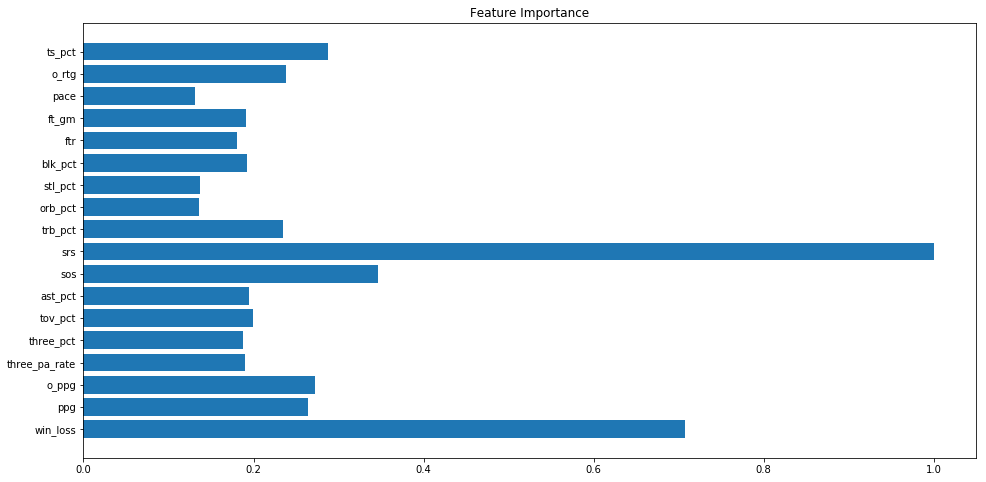

In [240]:
#Check how important each feature was
#Note that not every model will have the feature_importances_ method
features = ['win_loss', 'ppg', 'o_ppg', 'three_pa_rate', 'three_pct', 'tov_pct', 'ast_pct', 'sos', 
           'srs', 'trb_pct', 'orb_pct', 'stl_pct', 'blk_pct', 'ftr', 'ft_gm', 'pace', 'o_rtg', 'ts_pct']

def showFeatImport(features):
    fx_imp = pd.Series(model.feature_importances_, index=features)
    fx_imp /= fx_imp.max()
    
    fig1, ax1 = plt.subplots(1, figsize = (16,8))
    plt.barh(features, fx_imp)
    plt.title('Feature Importance')
    fig1.savefig('Feature Importance for Random Forest.png', dpi=300)
    
showFeatImport(features)

Last but not least, I filled out my bracket! It's a pretty scratch bracket in general, although I think it's interesting that my model suggests Duke is pretty overrated (at least as far as public perception is concerned). They have the best chance of winning according to Vegas, but don't even make it to the Final 4 in my bracket.

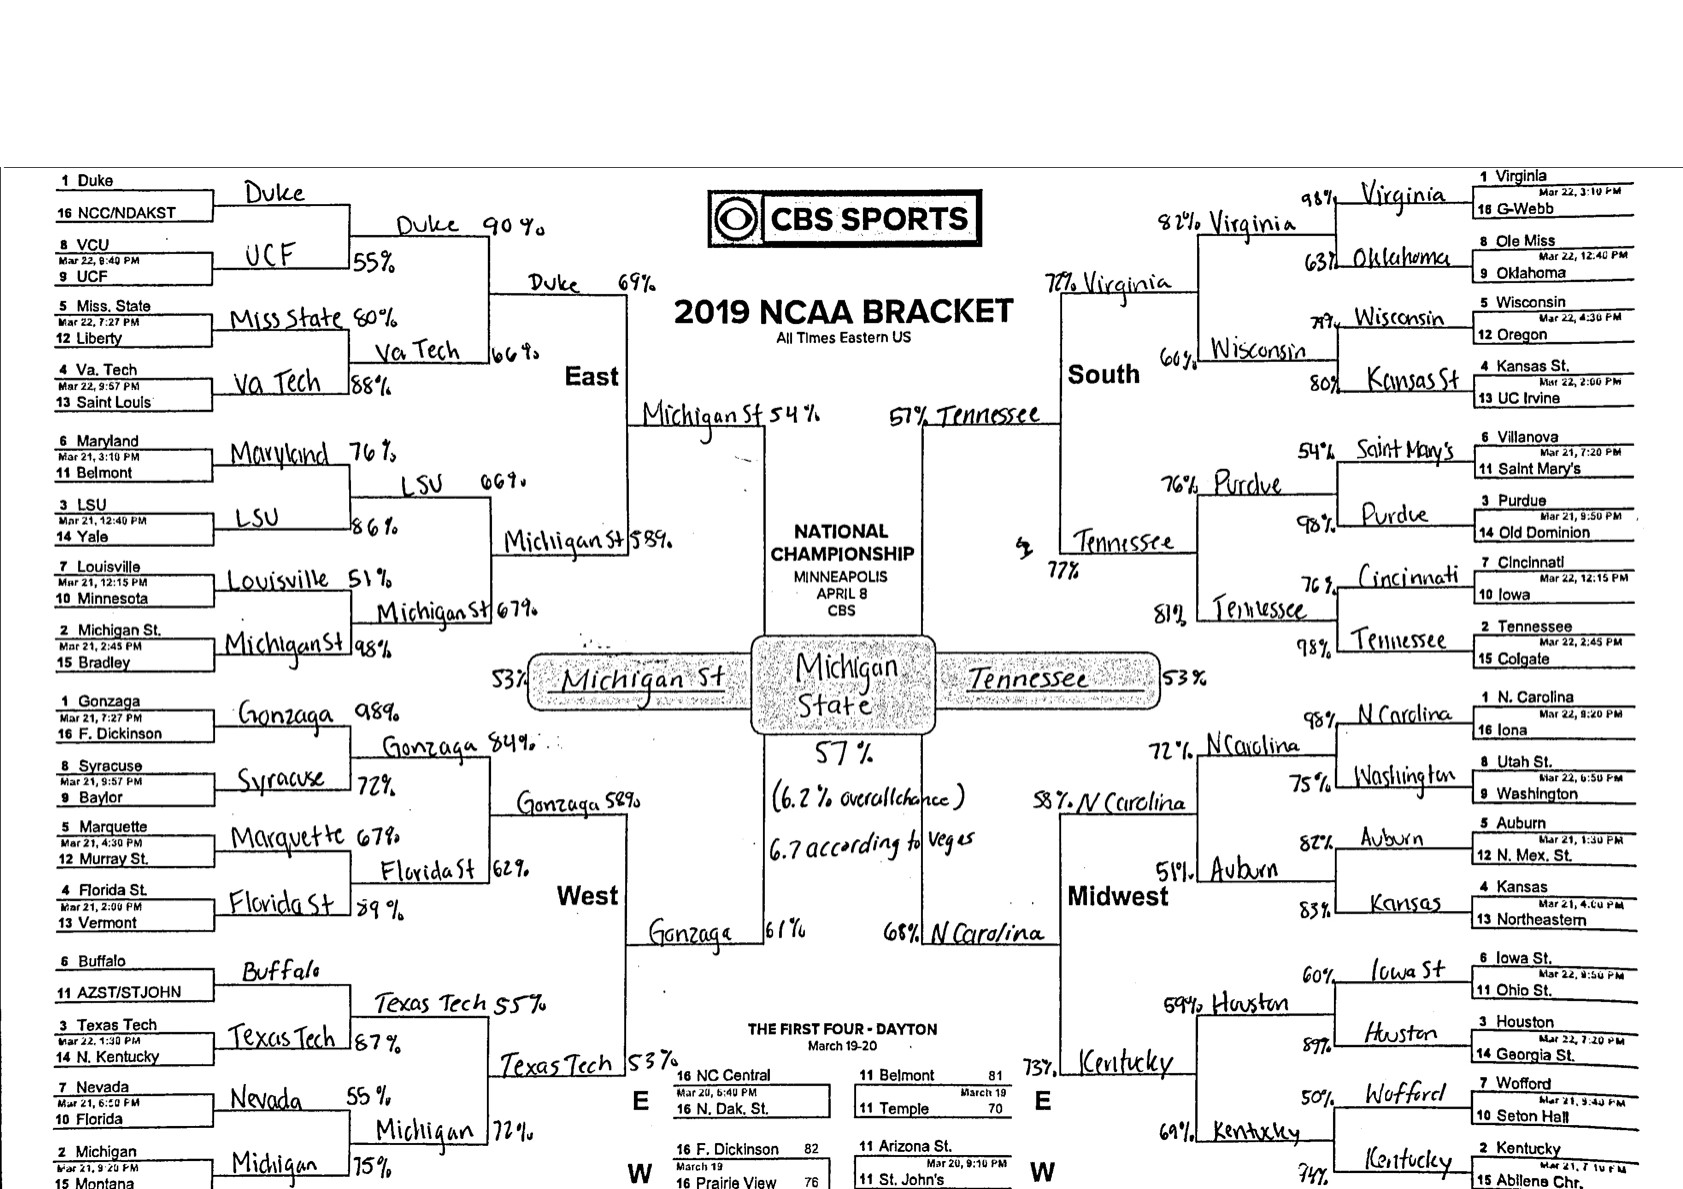

In [251]:
from IPython.display import display, Image
display(Image(filename='FinishedBracket.JPG'))

In [229]:
#Use the model to predict a game!
#Have to use .predict instead of .predict_proba depending on the model
def predictGame(team1_name, team2_name, year):
    team1_id = getTeamId(team1_name)
    team2_id = getTeamId(team2_name)
    team1_vector = makeSeasonVector(team1_id, year)
    team2_vector = makeSeasonVector(team2_id, year)
    
    diff = [a-b for a,b in zip(team1_vector, team2_vector)]
    return print(team1_name, 'has a', model.predict_proba([diff])[0,1] * 100, 'percent chance of winning.')

predictGame('Utah St', 'Washington', 2019)

[[0.66875 0.33125]]
Utah St has a 33.125 percent chance of winning.


### Improving The Model
As I showed before, all the models I tested had an accuracy percentage in the mid 70's. The logical question to ask about that is "can it be improved?". The answer is almost certainly yes. My model as it currently stands uses end of season stats to predict the results of games that happened before the season ended. Thus, the feature vectors for each team are calculated on a season by season basis instead of on a game by game basis. Becuase of this, my model can't completely account for teams getting hot right before March Madness begins, improving over the course of the season, having injuries to key players, or a host of other possible situations. There are two solutions I would like to try out next year to see if they can make my model better.
1. Have the features vector change as the season progresses. For example, it could instead hold the statistics for only a team's last 10 games instead of for the whole season. This could help improve accurace by capturing a better picture of how a team is playing at the time of a specific game rather than how they played over the whole season on average.
2. Completely change my model to be player-based instead of team-based. This would help account for injuries and suspensions and the like. Perhaps I could even combine these two concepts and have a model that's based on some sort of rolling player averages.

That's all I have to write for today, hope you found it interesting! 

All code for this project can be found on my github linked at the bottom of the blog.